# Indexing

In [9]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import join_date_time

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format

For this section we'll work with the flights dataset.

In [10]:
columns = [
    'FL_DATE', 'UNIQUE_CARRIER', 'AIRLINE_ID',
    'TAIL_NUM', 'FL_NUM', 'ORIGIN', 'DEST',
    'DEP_TIME', 'DEP_DELAY', 'ARR_TIME',
    'ARR_DELAY', 'CANCELLED'
]

flights = (pd.read_csv("data/flights.csv.zip",
                       parse_dates=["FL_DATE"],
                       usecols=columns)
             .rename(columns=str.lower)
             .pipe(join_date_time))

flights.head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
0,2014-01-01,AA,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
1,2014-01-01,AA,19805,N339AA,2,LAX,JFK,"1,132.00",122.00,"1,951.00",111.00,0.00,2014-01-01 19:51:00,2014-01-01 11:32:00
2,2014-01-01,AA,19805,N335AA,3,JFK,LAX,"1,157.00",-3.00,"1,523.00",13.00,0.00,2014-01-01 15:23:00,2014-01-01 11:57:00
3,2014-01-01,AA,19805,N367AA,5,DFW,HNL,"1,307.00",2.00,"1,746.00",1.00,0.00,2014-01-01 17:46:00,2014-01-01 13:07:00
4,2014-01-01,AA,19805,N364AA,6,OGG,DFW,"1,753.00",-2.00,452.00,-8.00,0.00,2014-01-01 04:52:00,2014-01-01 17:53:00


In [11]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471949 entries, 0 to 471948
Data columns (total 14 columns):
fl_date           471949 non-null datetime64[ns]
unique_carrier    471949 non-null object
airline_id        471949 non-null int64
tail_num          467903 non-null object
fl_num            471949 non-null int64
origin            471949 non-null object
dest              471949 non-null object
dep_time          441622 non-null float64
dep_delay         441622 non-null float64
arr_time          440453 non-null float64
arr_delay         439620 non-null float64
cancelled         471949 non-null float64
arr               440453 non-null datetime64[ns]
dep               441622 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(5), int64(2), object(4)
memory usage: 50.4+ MB


It covers January 2014. Each record has information about a single flight including the carrier, tail number, origin, destination, and delays.

To get a bit of intuition about the data we're working with, let's to a brief bit of exploratory analysis:

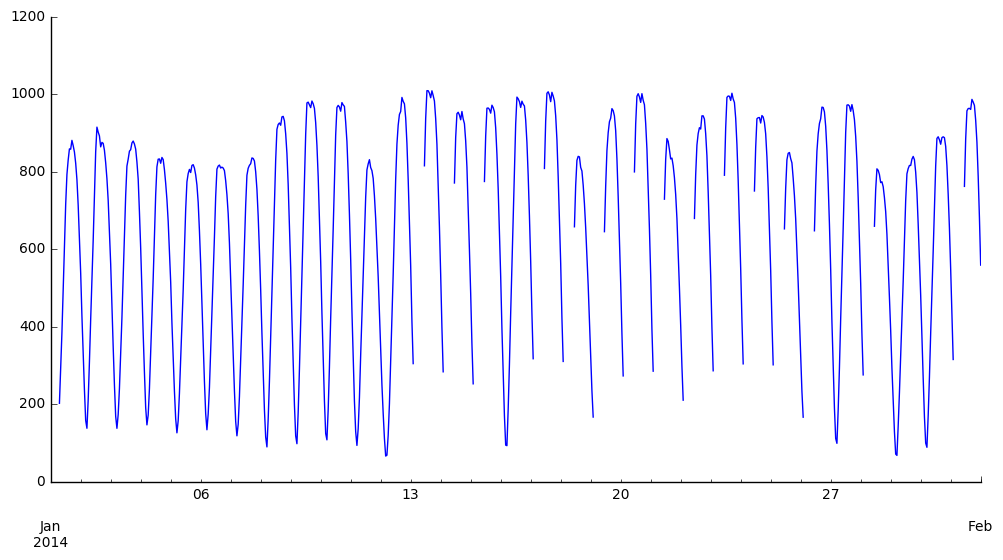

In [12]:
(flights.dep
    .value_counts()
    .resample('H')
    .sum()
    .rolling(8).mean()
    .plot(figsize=(12, 6)))
sns.despine()
plt.show()

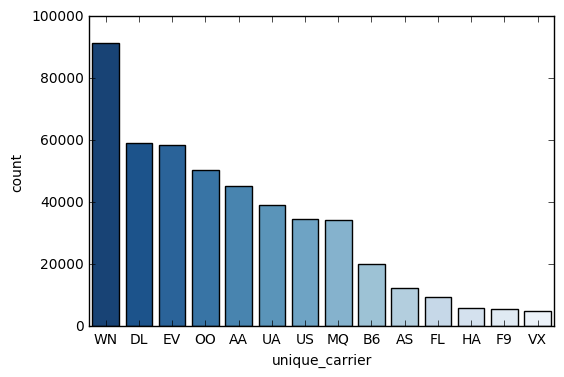

In [13]:
sns.countplot(flights.unique_carrier,
              order=flights.unique_carrier.value_counts().index,
              palette='Blues_r')
plt.show();

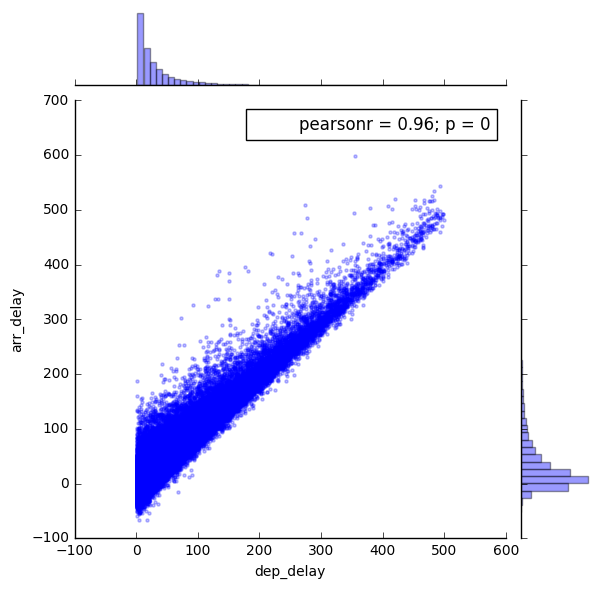

In [14]:
sns.jointplot('dep_delay', 'arr_delay',
              flights[(flights.dep_delay > 1) & (flights.dep_delay < 500)],
              alpha=.25, marker='.')
plt.show()

And now to the incredibly dry (but important!) topic of indexing.
It's a good starting point, because it comes up in so many other places;
It's a terrible starting point because it's somewhat complicated, and somewhat boring.

Indexing tries to do so much.

- Like lists, you can index by integer location.
- Like dictionaries, you can index by label.
- Like NumPy arrays, you can index by boolean masks.
- You can index with scalar, `slice`s, or arrays
- Any of these should work on the index (row labels) or columns of a DataFrame.
- And any of these should work on Hierarchical indexes.

Let's get a DataFrame with a labeled index by selecting the
first flight for each carrier. We'll talk about `groupby` later.

In [15]:
# first
first = flights.groupby("unique_carrier").first()
first.head()

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
AS,2014-01-01,19930,N524AS,1,DCA,SEA,733.00,-12.00,"1,022.00",-15.00,0.00,2014-01-01 10:22:00,2014-01-01 07:33:00
B6,2014-01-01,20409,N317JB,1236,SJU,STT,809.00,-11.00,840.00,-14.00,0.00,2014-01-01 08:40:00,2014-01-01 08:09:00
DL,2014-01-01,19790,N911DL,7,ATL,MIA,839.00,70.00,"1,027.00",62.00,0.00,2014-01-01 10:27:00,2014-01-01 08:39:00
EV,2014-01-01,20366,N906EV,2500,DFW,HOU,"1,805.00",70.00,"2,005.00",65.00,1.00,2014-01-01 20:05:00,2014-01-01 18:05:00


In [16]:
first.shape

(14, 13)

# The Basic Rules

The one cell to take away from our session:

1. Use `.loc` for label-based indexing
2. Use `.iloc` for position-based indexing

## Label-Based Indexing

In [17]:
first.index

Index(['AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'FL', 'HA', 'MQ', 'OO', 'UA', 'US',
       'VX', 'WN'],
      dtype='object', name='unique_carrier')

In [18]:
carriers = ['AA', 'DL', 'US', 'WN']
# Select those carriers by label
first.loc[carriers]

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
DL,2014-01-01,19790,N911DL,7,ATL,MIA,839.00,70.00,"1,027.00",62.00,0.00,2014-01-01 10:27:00,2014-01-01 08:39:00
US,2014-01-01,20355,N650AW,553,SEA,PHL,834.00,-1.00,"1,632.00",-9.00,0.00,2014-01-01 16:32:00,2014-01-01 08:34:00
WN,2014-01-01,19393,N412WN,2,DEN,LGA,"1,045.00",15.00,"1,624.00",9.00,0.00,2014-01-01 16:24:00,2014-01-01 10:45:00


The more general form is `.loc[row_indexer, column_indexer]`, where an indexer is  one of

- A scalar or array of row labels
- A `slice` object
- A boolean mask

Let's step through these possibilites:

## Scalar / Array

In [19]:
# select just `carriers` and origin, dest, and dep_delay
first.loc[carriers, ['origin', 'dest', 'dep_delay']]

,origin,dest,dep_delay
unique_carrier,,,
AA,JFK,LAX,14.00
DL,ATL,MIA,70.00
US,SEA,PHL,-1.00
WN,DEN,LGA,15.00


Pandas will *reduce dimensionality* when possible, so slicing with a scalar
will return a Series (usually; the exception being duplicates in the index or columns)

In [20]:
# select just tail_num for those `carriers`
first.loc[carriers, 'tail_num']

unique_carrier
AA    N338AA
DL    N911DL
US    N650AW
WN    N412WN
Name: tail_num, dtype: object

## `slice` objects

`slice`s make the most sense when your index is sorted. Groupby sorts the keys for us, so  we're OK here.

In [21]:
# slice from AA to DL
first.loc['AA':'BZ']

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
AS,2014-01-01,19930,N524AS,1,DCA,SEA,733.00,-12.00,"1,022.00",-15.00,0.00,2014-01-01 10:22:00,2014-01-01 07:33:00
B6,2014-01-01,20409,N317JB,1236,SJU,STT,809.00,-11.00,840.00,-14.00,0.00,2014-01-01 08:40:00,2014-01-01 08:09:00


Notice that the slice is inclusive on *both* sides *when using `.loc`* (`.iloc` follows the usual python rules of closed on the left, open on the right).

## Boolean Indexing

This is esstentially a SQL `WHERE` clause. For examples, get the top 5 most common carriers.

In [22]:
# Get the counts for `flights.unique_carrier`
vc = flights.unique_carrier.value_counts()
vc

WN    91564
DL    59030
EV    58508
OO    50484
AA    45401
      ...  
AS    12403
FL     9405
HA     6019
F9     5736
VX     4810
Name: unique_carrier, dtype: int64

In [23]:
# Get a boolean mask for whether `counts` is in the top 5.
mask = vc.index.isin(vc.index[:5])
labels = vc.index[mask]
labels

Index(['WN', 'DL', 'EV', 'OO', 'AA'], dtype='object')

*We used the `.isin` method there, which is handy for checking membership of a set. It's available on `Index`, `Series`, and `DataFrame`*.

In [24]:
# Filter to the `mask` rows and ['tail_num', 'fl_num']
first.loc[labels, ['tail_num', 'fl_num']]

,tail_num,fl_num
WN,N412WN,2
DL,N911DL,7
EV,N906EV,2500
OO,N868CA,2612
AA,N338AA,1


The reguler `__getitem__` (square brackets) also accepts a boolean mask, which will subset the rows. This is similar to NumPy.

In [25]:
first[mask]

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
AS,2014-01-01,19930,N524AS,1,DCA,SEA,733.00,-12.00,"1,022.00",-15.00,0.00,2014-01-01 10:22:00,2014-01-01 07:33:00
B6,2014-01-01,20409,N317JB,1236,SJU,STT,809.00,-11.00,840.00,-14.00,0.00,2014-01-01 08:40:00,2014-01-01 08:09:00
DL,2014-01-01,19790,N911DL,7,ATL,MIA,839.00,70.00,"1,027.00",62.00,0.00,2014-01-01 10:27:00,2014-01-01 08:39:00
EV,2014-01-01,20366,N906EV,2500,DFW,HOU,"1,805.00",70.00,"2,005.00",65.00,1.00,2014-01-01 20:05:00,2014-01-01 18:05:00


Boolean indexers are useful because so many operations can produce an array of booleans.

- null checks (`.isnull`, `.notnull`)
- container checks (`.isin`)
- boolean aggregations (`.any`, `.all`)
- comparisions (`.gt`, `.lt`, etc.)

In [26]:
# Select rows where `dep` is null

flights.loc[flights.dep.isnull()]

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
95,2014-01-01,AA,19805,N583AA,193,MCI,ORD,nan,nan,nan,nan,1.00,NaT,NaT
96,2014-01-01,AA,19805,N583AA,193,ORD,MCI,nan,nan,nan,nan,1.00,NaT,NaT
104,2014-01-01,AA,19805,N3DRAA,197,SFO,ORD,nan,nan,nan,nan,1.00,NaT,NaT
198,2014-01-01,AA,19805,N3CKAA,288,ORD,BOS,nan,nan,nan,nan,1.00,NaT,NaT
321,2014-01-01,AA,19805,N3EAAA,359,LGA,ORD,nan,nan,nan,nan,1.00,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471733,2014-01-31,UA,19977,NaN,1599,ORD,RIC,nan,nan,nan,nan,1.00,NaT,NaT
471772,2014-01-31,UA,19977,NaN,1643,DEN,EWR,nan,nan,nan,nan,1.00,NaT,NaT
471806,2014-01-31,UA,19977,NaN,1668,SFO,EWR,nan,nan,nan,nan,1.00,NaT,NaT
471912,2014-01-31,OO,20304,N716SK,5546,DEN,ASE,nan,nan,nan,nan,1.00,NaT,NaT


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Filter down to rows where the departure **`hour`** is before 6:00 or after 18:00.

- Hint: Use the `flights.dep.dt` namespace
- Hint: Be careful with the order of operations

In [29]:
%load solutions/indexing_01.py

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
2571,2014-01-01,DL,19790,N617DL,39,ATL,MCO,"1,552.00",-3.00,"1,714.00",-6.00,0.00,2014-01-01 17:14:00,2014-01-01 15:52:00
2624,2014-01-01,DL,19790,N978DL,331,ATL,MCO,"1,815.00",20.00,"1,944.00",19.00,0.00,2014-01-01 19:44:00,2014-01-01 18:15:00
2800,2014-01-01,DL,19790,N922DL,786,ATL,LGA,"1,747.00",2.00,"1,929.00",-35.00,0.00,2014-01-01 19:29:00,2014-01-01 17:47:00
2809,2014-01-01,DL,19790,N901DE,802,ATL,LGA,"1,443.00",-2.00,"1,640.00",-17.00,0.00,2014-01-01 16:40:00,2014-01-01 14:43:00
2854,2014-01-01,DL,19790,N667DN,871,ATL,MCO,"2,149.00",-1.00,"2,314.00",-1.00,0.00,2014-01-01 23:14:00,2014-01-01 21:49:00


# Position-Based Indexing

Uses `.iloc`.

In [33]:
# select the first two rows, and the 3rd, 4th, and 5th columns
flights.iloc[:2, 3:6]

,tail_num,fl_num,origin
0,N338AA,1,JFK
1,N339AA,2,LAX


The same general form applies. Use `.iloc[row_indexer, column_indexer]`, where an indexer is a scalar or array of **positions**, a slice (by position) or a boolean mask. Notice that the slice is open on the right (like regular python slices).